# Lab2 DeepConvNet

In [1]:
import os
import torch
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dataloader import read_bci_data

1.2.0
cuda


## TensorDataset & DataLoader

In [2]:
X_train,y_train,X_test,y_test=read_bci_data()
dataset=TensorDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
loader_train=DataLoader(dataset,batch_size=64)
dataset=TensorDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
loader_test=DataLoader(dataset,batch_size=64)
print(f'test dataset:\n{dataset[:3]}')

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
test dataset:
(tensor([[[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
          [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],


        [[[ -1.6904,  -3.2816,  -3.6523,  ...,   4.0093,   0.7018,   0.7155],
          [  3.4033,   2.0698,  -1.6959,  ...,   7.7458,   3.5498,   3.7207]]],


        [[[ -2.6835,  -0.4836,   1.9848,  ...,  -3.9513,   0.4729,   5.2923],
          [  2.6602,   3.9587,   4.9871,  ...,  -0.6675,  -0.2266,   0.0633]]]],
       dtype=torch.float64), tensor([1., 0., 1.], dtype=torch.float64))


sample_id:823


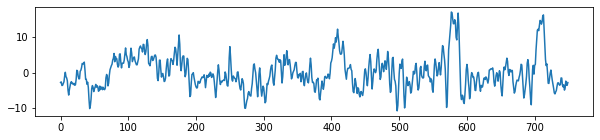

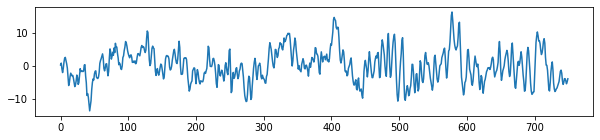

In [3]:
randi=int(np.random.randint(0,X_train.shape[0],1))
print(f'sample_id:{randi}')
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,0])
plt.figure(figsize=(10,2))
plt.plot(X_train[randi,0,1])

## Model
![deepConvNet](deepconvnet.png)  

In [4]:
class EEGNet(nn.Module):
    def __init__(self,activation=nn.ELU()):
        super(EEGNet,self).__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),stride=(1,1),padding=(0,25),bias=False),
            nn.BatchNorm2d(16,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=0.25)
        )
        self.seperableConv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7),bias=False),
            nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True),
            activation,
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify=nn.Linear(736,2)
    def forward(self,X):
        out=self.firstconv(X)
        out=self.depthwiseConv(out)
        out=self.seperableConv(out)
        out=out.view(out.shape[0],-1)
        out=self.classify(out)
        return out

## Train
loss function: cross entropy  
optimizer: adam  
learning rate: 0.001  
epoch=150  
activation fuction: ReLU/LeakyReLU/ELU  

In [5]:
Loss=nn.CrossEntropyLoss()
lr=0.001
epochs=150

In [6]:
def train_with_different_activation(loader_train,loader_test,activations,device):
    """
    Args:
        loader_train: training dataloader
        loader_test: testing dataloader
        activations: {ReLU,LeakyReLU,ELU} pytorch layer
        device: pytorch device gpu,cpu
    Return:
        dataframe: with column 'epoch','ReLU_train','ReLU_test','LeakyReLU_train'...
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    for name,activation in activations.items():
        """
        train model with an specific activation function
        """
        model=EEGNet(activation)
        model.to(device)
        optimizer=torch.optim.Adam(model.parameters(),lr=lr)
        acc_train=list()
        acc_test=list()
        for epoch in range(1,epochs+1):
            """
            train
            """
            model.train()
            loss=0
            correct=0
            for idx,(data,target) in enumerate(loader_train):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long) #target type has to be 'long'
                predict=model(data)
                loss+=Loss(predict,target)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()
            loss/=len(loader_train.dataset)
            correct=100.*correct/len(loader_train.dataset)
            print(f'epcoh{epoch:>3d}  loss:{loss:.4f}  acc:{correct:.1f}%')
            acc_train.append(correct)
            """
            test
            """
            model.eval()
            correct=0
            for idx,(data,target) in enumerate(loader_test):
                data=data.to(device,dtype=torch.float)
                target=target.to(device,dtype=torch.long)
                predict=model(data)
                correct+=predict.max(dim=1)[1].eq(target).cpu().sum()
            correct=100.*correct/len(loader_test.dataset)
            acc_test.append(correct)
        df[name+'_train']=acc_train
        df[name+'_test']=acc_test
        torch.save(model.state_dict(),os.path.join('eeg models',name+'.pt'))
    return df

In [7]:
activations={'ReLU':nn.ReLU(),'LeakyReLU':nn.LeakyReLU(),'ELU':nn.ELU()}
df=train_with_different_activation(loader_train,loader_test,activations,device)

epcoh  1  loss:0.0115  acc:53.0%
epcoh  2  loss:0.0130  acc:66.0%
epcoh  3  loss:0.0138  acc:64.0%
epcoh  4  loss:0.0128  acc:67.0%
epcoh  5  loss:0.0161  acc:56.0%
epcoh  6  loss:0.0237  acc:57.0%
epcoh  7  loss:0.0123  acc:70.0%
epcoh  8  loss:0.0126  acc:67.0%
epcoh  9  loss:0.0110  acc:70.0%
epcoh 10  loss:0.0088  acc:74.0%
epcoh 11  loss:0.0090  acc:72.0%
epcoh 12  loss:0.0084  acc:72.0%
epcoh 13  loss:0.0075  acc:77.0%
epcoh 14  loss:0.0077  acc:76.0%
epcoh 15  loss:0.0077  acc:75.0%
epcoh 16  loss:0.0073  acc:77.0%
epcoh 17  loss:0.0072  acc:77.0%
epcoh 18  loss:0.0073  acc:77.0%
epcoh 19  loss:0.0076  acc:77.0%
epcoh 20  loss:0.0073  acc:75.0%
epcoh 21  loss:0.0069  acc:79.0%
epcoh 22  loss:0.0068  acc:78.0%
epcoh 23  loss:0.0066  acc:78.0%
epcoh 24  loss:0.0067  acc:80.0%
epcoh 25  loss:0.0072  acc:77.0%
epcoh 26  loss:0.0079  acc:76.0%
epcoh 27  loss:0.0079  acc:75.0%
epcoh 28  loss:0.0074  acc:78.0%
epcoh 29  loss:0.0069  acc:78.0%
epcoh 30  loss:0.0064  acc:81.0%
epcoh 31  

## Plot

In [40]:
df

,epoch,ReLU_train,ReLU_test,LeakyReLU_train,LeakyReLU_test,ELU_train,ELU_test
0,1,tensor(53),tensor(60),tensor(52),tensor(65),tensor(58),tensor(68)
1,2,tensor(66),tensor(59),tensor(62),tensor(58),tensor(70),tensor(67)
2,3,tensor(64),tensor(59),tensor(51),tensor(69),tensor(67),tensor(66)
3,4,tensor(67),tensor(61),tensor(66),tensor(65),tensor(70),tensor(69)
4,5,tensor(56),tensor(68),tensor(71),tensor(71),tensor(70),tensor(66)
5,6,tensor(57),tensor(68),tensor(69),tensor(71),tensor(67),tensor(68)
6,7,tensor(70),tensor(65),tensor(70),tensor(69),tensor(70),tensor(69)
7,8,tensor(67),tensor(71),tensor(74),tensor(71),tensor(73),tensor(68)
8,9,tensor(70),tensor(68),tensor(73),tensor(72),tensor(71),tensor(69)
9,10,tensor(74),tensor(71),tensor(71),tensor(71),tensor(72),tensor(69)


In [41]:
def plot(dataframe):
    fig=plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch',name,data=dataframe)
    plt.legend()
    return fig

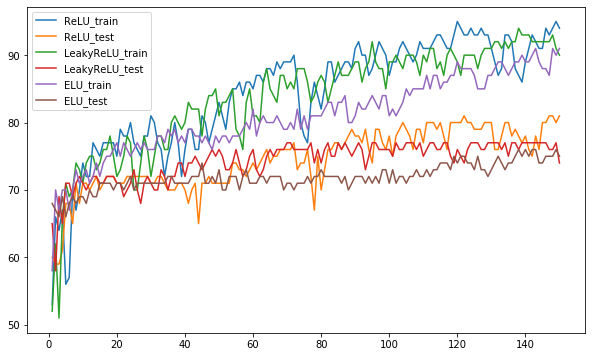

In [42]:
figure=plot(df)
figure.savefig('eeg result.png')